<a target="_blank" href="https://colab.research.google.com/github/victorlymarev/pandas/blob/main/notebooks/20-time-series-and-windows.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os

Читаем данные

In [30]:
path_ltc_sample = '../tables/ltc_sample.parquet' if os.path.exists('../tables/ltc_sample.parquet') else 'https://drive.google.com/uc?id=1XaThogOOqKjJj50LvfJ9WqutjMAC5AxA'

ltc = pd.read_parquet(path_ltc_sample)
ltc.head()

,date,price,volume
0,2013-11-13 15:00:56,5.00,12.874000
1,2013-11-13 15:58:20,5.00,0.900000
2,2013-11-16 18:58:57,4.30,0.067440
3,2013-11-16 18:59:16,4.25,5.000000
4,2013-11-19 03:24:48,9.90,0.117018


#### Рисуем графики

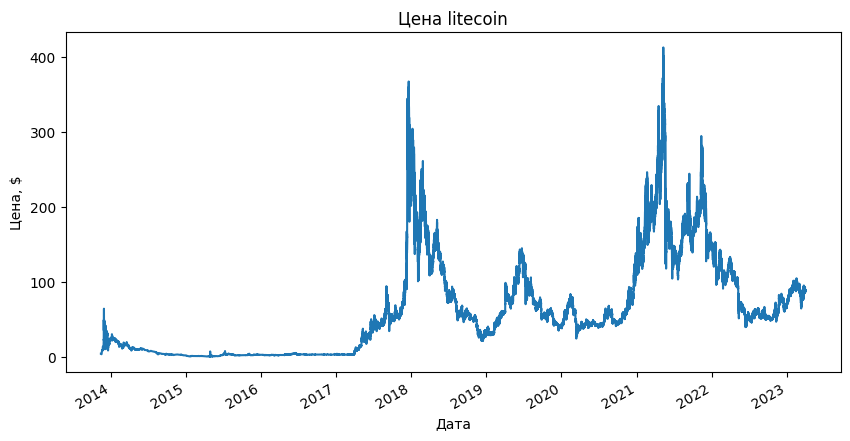

In [31]:
plt.figure(figsize=(10, 5))
ltc.set_index('date')['price'].plot()
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.title('Цена litecoin')
plt.show()

### Делаем лаги

In [32]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(shift_1 = lambda x: x['price'].shift(1))
    .assign(shift_2 = lambda x: x['price'].shift(2))
)

,price,shift_1,shift_2
563279,117.12,NaN,NaN
682710,62.90,117.12,NaN
821866,87.50,62.90,117.12
1145589,265.89,87.50,62.90
1762037,55.42,265.89,87.50


In [33]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(shift_minus_1 = lambda x: x['price'].shift(-1))
    .assign(shift_minus_2 = lambda x: x['price'].shift(-2))
)

,price,shift_minus_1,shift_minus_2
563279,117.12,62.90,87.50
682710,62.90,87.50,265.89
821866,87.50,265.89,55.42
1145589,265.89,55.42,NaN
1762037,55.42,NaN,NaN


#### Разница с предыдущим значением

In [34]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(diff_1 = lambda x: x['price'].diff(1))
    .assign(diff_manual_1 = lambda x: x['price'] - x['price'].shift(1))
 
    .assign(diff_2 = lambda x: x['price'].diff(2))
    .assign(diff_manual_2 = lambda x: x['price'] - x['price'].shift(2))
)

,price,diff_1,diff_manual_1,diff_2,diff_manual_2
563279,117.12,NaN,NaN,NaN,NaN
682710,62.90,-54.22,-54.22,NaN,NaN
821866,87.50,24.60,24.60,-29.62,-29.62
1145589,265.89,178.39,178.39,202.99,202.99
1762037,55.42,-210.47,-210.47,-32.08,-32.08


#### Прирост к предыдущему наблюдению

In [35]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(pct_change_1 = lambda x: x['price'].pct_change(1))
    .assign(pct_change_manual_1 = lambda x: x['price'] / x['price'].shift(1) - 1)

    .assign(pct_change_2 = lambda x: x['price'].pct_change(2))
    .assign(pct_change_manual_2 = lambda x: x['price'] / x['price'].shift(2) - 1)
)

,price,pct_change_1,pct_change_manual_1,pct_change_2,pct_change_manual_2
563279,117.12,NaN,NaN,NaN,NaN
682710,62.90,-0.462944,-0.462944,NaN,NaN
821866,87.50,0.391097,0.391097,-0.252903,-0.252903
1145589,265.89,2.038743,2.038743,3.227186,3.227186
1762037,55.42,-0.791568,-0.791568,-0.366629,-0.366629


## Приводим временной ряд к фиксированной частоте

In [36]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .head()
)

,price,volume
date,,
2013-11-13 15:00:56,5.00,12.874000
2013-11-13 15:58:20,5.00,0.900000
2013-11-16 18:58:57,4.30,0.067440
2013-11-16 18:59:16,4.25,5.000000
2013-11-19 03:24:48,9.90,0.117018


In [37]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .asfreq(freq='30 min')
    .head()
)

,price,volume
date,,
2013-11-13 15:00:56,5.0,12.874
2013-11-13 15:30:56,NaN,NaN
2013-11-13 16:00:56,NaN,NaN
2013-11-13 16:30:56,NaN,NaN
2013-11-13 17:00:56,NaN,NaN


Заполняем последним доступным значением

In [38]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .asfreq(freq='30 min', method='ffill') # method='pad'
    .head()
)

,price,volume
date,,
2013-11-13 15:00:56,5.0,12.874
2013-11-13 15:30:56,5.0,12.874
2013-11-13 16:00:56,5.0,0.900
2013-11-13 16:30:56,5.0,0.900
2013-11-13 17:00:56,5.0,0.900


In [39]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    ['price']
    .asfreq(freq='30 min', method='backfill') # method='bfill'
    .head()
)

date
2013-11-13 15:00:56    5.0
2013-11-13 15:30:56    5.0
2013-11-13 16:00:56    4.3
2013-11-13 16:30:56    4.3
2013-11-13 17:00:56    4.3
Freq: 30T, Name: price, dtype: float64

In [40]:
# Можно поменять индекс первого наблюдения
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .rename({pd.Timestamp('2013-11-13 15:00:56'): pd.Timestamp('2013-10-24 15:00')}) # не забудьте обернуть Timestamp
    .asfreq(freq='30 min', method='ffill') # method='bfill'
    .head()
)

,price,volume
date,,
2013-10-24 15:00:00,5.0,12.874
2013-10-24 15:30:00,5.0,12.874
2013-10-24 16:00:00,5.0,12.874
2013-10-24 16:30:00,5.0,12.874
2013-10-24 17:00:00,5.0,12.874


## Окна

### resemple

In [41]:
ltc.tail(10000).resample('30 min', on='date').apply(lambda x: list(x))

,price,volume
date,,
2023-03-22 20:00:00,"[82.11, 82.35, 82.37, 83.17, 83.2, 83.2, 83.36...","[0.2475, 0.67058101, 6.5, 0.99029232, 0.426831..."
2023-03-22 20:30:00,"[83.46, 83.36, 83.5, 83.49, 83.48, 83.46, 83.4...","[0.22114101, 1.9657, 0.09494336, 11.06042298, ..."
2023-03-22 21:00:00,"[86.74, 86.75, 87.0, 87.0, 87.0, 87.0, 87.06, ...","[7.43e-06, 1.63140257, 2.08729533, 1.0, 0.1185..."
2023-03-22 21:30:00,"[86.58, 86.76, 86.74, 86.83, 86.89, 86.79, 86....","[4.0, 0.09427302, 1.7486907, 0.19683366, 1.601..."
2023-03-22 22:00:00,"[85.97, 85.99, 86.0, 86.0, 86.0, 86.0, 86.02, ...","[1.57348669, 3.39284077, 5.38101776, 8.4483625..."
...,...,...
2023-03-31 21:30:00,"[89.69, 89.71, 89.99, 89.94, 89.94, 89.98, 89....","[5.74249123, 2.35713426, 0.49334389, 0.1342986..."
2023-03-31 22:00:00,"[89.95, 89.91, 89.85, 89.86, 89.93, 90.05, 90.03]","[3.73812782, 1.7934088, 2.96755156, 0.1446472,..."
2023-03-31 22:30:00,"[90.08, 90.12, 90.13, 90.12, 90.14, 90.13, 90....","[5.55802578, 0.7322756, 4.58355146, 7.56720473..."


In [42]:
ltc.resample('30 min', on='date')

In [43]:
ltc.set_index('date').resample('30 min')

### После окон можно использовать те же функции, что и после groupby

In [44]:
ltc.resample('30 min', on='date')['price'].mean()

date
2013-11-13 15:00:00     5.000000
2013-11-13 15:30:00     5.000000
2013-11-13 16:00:00          NaN
2013-11-13 16:30:00          NaN
2013-11-13 17:00:00          NaN
                         ...    
2023-03-31 21:30:00    89.990345
2023-03-31 22:00:00    89.940000
2023-03-31 22:30:00    90.108824
2023-03-31 23:00:00    89.868095
2023-03-31 23:30:00    89.743636
Freq: 30T, Name: price, Length: 164418, dtype: float64

#### Открытие (первое значение), максимум, минимум, закрытие (последнее значение)

In [45]:
ltc.resample('30 min', on='date')['price'].ohlc()

,open,high,low,close
date,,,,
2013-11-13 15:00:00,5.00,5.00,5.00,5.00
2013-11-13 15:30:00,5.00,5.00,5.00,5.00
2013-11-13 16:00:00,NaN,NaN,NaN,NaN
2013-11-13 16:30:00,NaN,NaN,NaN,NaN
2013-11-13 17:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-03-31 21:30:00,89.69,90.12,89.69,90.01
2023-03-31 22:00:00,89.95,90.05,89.85,90.03
2023-03-31 22:30:00,90.08,90.15,90.06,90.11


#### agg

In [46]:
ltc.resample('30 min', on='date')['price'].agg(['mean', 'max'])

,mean,max
date,,
2013-11-13 15:00:00,5.000000,5.00
2013-11-13 15:30:00,5.000000,5.00
2013-11-13 16:00:00,NaN,NaN
2013-11-13 16:30:00,NaN,NaN
2013-11-13 17:00:00,NaN,NaN
...,...,...
2023-03-31 21:30:00,89.990345,90.12
2023-03-31 22:00:00,89.940000,90.05
2023-03-31 22:30:00,90.108824,90.15


#### Первое значение

In [47]:
ltc.resample('30 min', on='date')['price'].first()

date
2013-11-13 15:00:00     5.00
2013-11-13 15:30:00     5.00
2013-11-13 16:00:00      NaN
2013-11-13 16:30:00      NaN
2013-11-13 17:00:00      NaN
                       ...  
2023-03-31 21:30:00    89.69
2023-03-31 22:00:00    89.95
2023-03-31 22:30:00    90.08
2023-03-31 23:00:00    90.05
2023-03-31 23:30:00    89.88
Freq: 30T, Name: price, Length: 164418, dtype: float64

#### Последнее значение

In [48]:
ltc.resample('30 min', on='date')['price'].last()

date
2013-11-13 15:00:00     5.00
2013-11-13 15:30:00     5.00
2013-11-13 16:00:00      NaN
2013-11-13 16:30:00      NaN
2013-11-13 17:00:00      NaN
                       ...  
2023-03-31 21:30:00    90.01
2023-03-31 22:00:00    90.03
2023-03-31 22:30:00    90.11
2023-03-31 23:00:00    89.84
2023-03-31 23:30:00    89.58
Freq: 30T, Name: price, Length: 164418, dtype: float64

#### Можно использовать свои функции

In [49]:
ltc.set_index('date')['price'].resample('d').agg(lambda x: x.iloc[::10].mean())

date
2013-11-13     5.000000
2013-11-14          NaN
2013-11-15          NaN
2013-11-16     4.300000
2013-11-17          NaN
                ...    
2023-03-27    90.372232
2023-03-28    87.363587
2023-03-29    91.243333
2023-03-30    89.553269
2023-03-31    89.235143
Freq: D, Name: price, Length: 3426, dtype: float64

## rolling

Скользящее окно

In [50]:
path_stocks = '../tables/stocks.parquet' if os.path.exists('../tables/stocks.parquet') else 'https://drive.google.com/uc?id=1weGquTtmR92mKYAeZhZCFHJjndyoSXZt'

stocks = pd.read_parquet(path_stocks)
stocks.head()

,Цена,Откр.,Макс.,Мин.
Дата,,,,
2018-02-01,180.733,179.880,183.409,178.371
2019-02-01,179.218,179.143,180.669,177.728
2021-02-01,229.402,228.290,229.627,226.187
2022-02-01,311.075,315.381,317.571,305.878
2018-03-01,180.570,179.994,182.500,178.843


In [51]:
stocks['Цена'].head()

Дата
2018-02-01    180.733
2019-02-01    179.218
2021-02-01    229.402
2022-02-01    311.075
2018-03-01    180.570
Name: Цена, dtype: float64

In [52]:
[list(window) for window in stocks['Цена'].round(3).rolling(window=4)][:10]

[[180.733],
 [180.733, 179.218],
 [180.733, 179.218, 229.402],
 [180.733, 179.218, 229.402, 311.075],
 [179.218, 229.402, 311.075, 180.57],
 [229.402, 311.075, 180.57, 171.659],
 [311.075, 180.57, 171.659, 237.103],
 [180.57, 171.659, 237.103, 173.481],
 [171.659, 237.103, 173.481, 181.476],
 [237.103, 173.481, 181.476, 245.93]]

In [53]:
stocks['Цена'].rolling(window=4).mean().head(8)

Дата
2018-02-01          NaN
2019-02-01          NaN
2021-02-01          NaN
2022-02-01    225.10700
2018-03-01    225.06625
2019-03-01    223.17650
2021-03-01    225.10175
2019-04-01    190.70325
Name: Цена, dtype: float64

In [54]:
stocks['Цена'].rolling(window=4, min_periods=1).mean().head(8)

Дата
2018-02-01    180.73300
2019-02-01    179.97550
2021-02-01    196.45100
2022-02-01    225.10700
2018-03-01    225.06625
2019-03-01    223.17650
2021-03-01    225.10175
2019-04-01    190.70325
Name: Цена, dtype: float64

#### Взять каждое второе наблюдение можно при помощи своей функции

In [55]:
(stocks
    ['Цена']
    .rolling(window=10, min_periods=1)
    .agg(['mean', lambda x: x[::2].mean()])
    .set_axis(['Среднее', 'Среднее за каждое второе наблюдение'], axis=1)
    .head()
)

,Среднее,Среднее за каждое второе наблюдение
Дата,,
2018-02-01,180.7330,180.733000
2019-02-01,179.9755,180.733000
2021-02-01,196.4510,205.067500
2022-02-01,225.1070,205.067500
2018-03-01,216.1996,196.901667


### expanding

Расширяющееся окно

In [56]:
stocks['Цена'].expanding().sum()

Дата
2018-02-01       180.733
2019-02-01       359.951
2021-02-01       589.353
2022-02-01       900.428
2018-03-01      1080.998
                 ...    
2021-08-31    265154.287
2022-08-31    265372.992
2018-10-31    265538.761
2019-10-31    265791.228
2022-10-31    265948.433
Name: Цена, Length: 1225, dtype: float64

In [57]:
stocks['Цена'].cumsum()

Дата
2018-02-01       180.733
2019-02-01       359.951
2021-02-01       589.353
2022-02-01       900.428
2018-03-01      1080.998
                 ...    
2021-08-31    265154.287
2022-08-31    265372.992
2018-10-31    265538.761
2019-10-31    265791.228
2022-10-31    265948.433
Name: Цена, Length: 1225, dtype: float64

In [58]:
stocks['Цена'].expanding().mean()

Дата
2018-02-01    180.733000
2019-02-01    179.975500
2021-02-01    196.451000
2022-02-01    225.107000
2018-03-01    216.199600
                 ...    
2021-08-31    217.161578
2022-08-31    217.162841
2018-10-31    217.120818
2019-10-31    217.149696
2022-10-31    217.100762
Name: Цена, Length: 1225, dtype: float64

### ewm

Окно с экспоненциально взвешенными операциями

In [59]:
stocks['Цена'].ewm(alpha=0.5)

ExponentialMovingWindow [alpha=0.5,min_periods=1,adjust=True,ignore_na=False,axis=0,method=single]

**adjust=True**
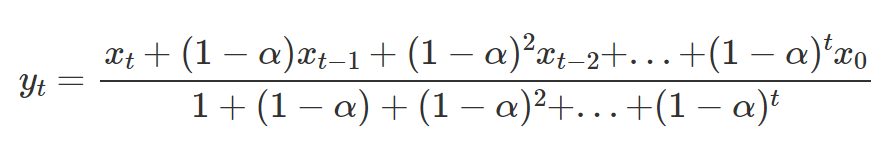

**adjust=False**

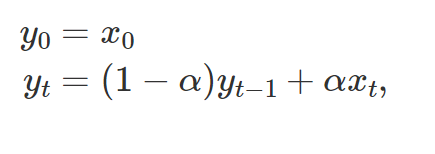

In [60]:
stocks['Цена'].ewm(alpha=0.5).mean()

Дата
2018-02-01    180.733000
2019-02-01    179.723000
2021-02-01    208.111000
2022-02-01    263.025133
2018-03-01    220.467645
                 ...    
2021-08-31    250.617709
2022-08-31    234.661355
2018-10-31    200.215177
2019-10-31    226.341089
2022-10-31    191.773044
Name: Цена, Length: 1225, dtype: float64

# Задания

#### Описание таблиц лежит [здесь](https://github.com/victorlymarev/pandas/tree/main/tables)

Некоторые таблицы занимают много памяти, поэтому каждые 5-10 заданий лучше перезапускайте ноутбук.

Если вы будете работать с этим ноутбуком в google colab и у вас что-то не будет работать, то раскоментируйте ячейку ниже (для этого выделите содержимое ячейки и нажмите на клавиши ctrl / (если смотреть по английской раскладке или ctrl . для русской), либо просто руками уберите # и пробел после нее в каждой строчке) и запустите ее.

In [ ]:
# import os
# os._exit(00)
# !pip install pyarrow pandas==1.5.3

### Задание 1

Для каждой даты выясните ли следующий день выходным (True если выходной, False если нет)

In [ ]:
import os
import pandas as pd

path_w_ends = '../tables/выходные.csv' if os.path.exists('../tables/выходные.csv') else 'https://drive.google.com/uc?id=1hAsoXSPTFihFmBuF-E0uSj9pX4gpojwC'

w_ends = pd.read_csv(path_w_ends)
w_ends.head()

In [ ]:
# напишите свой код здесь

### Задание 2

Постройте график суммарной выручки магазина 1 за каждый день. На том же графике разметите сглаженный график (тип сглаживания и длинну интервала сглаживания определите сами)

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 3

Для каждого месяца посчитать отношения числа проданных товаров в этом месяце к предыдущему, а так же прирост в выручке

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 4

Посчитать VaR и ES (на уровне 95%) для цены акций на 1 и на 10 торговых дней

VaR (value at risk) (на уровне 95%) - это 95 квантиль потерь (или пятый квантиль доходностей)
 
ES (expected shortfall) (на уровне 95%) - это средние убытки при условии, что состоялся неблагоприятный сценарий и убытки пробили 95% порог

In [ ]:
import os
import pandas as pd

path_stocks = '../tables/stocks.parquet' if os.path.exists('../tables/stocks.parquet') else 'https://drive.google.com/uc?id=1weGquTtmR92mKYAeZhZCFHJjndyoSXZt'

stocks = pd.read_parquet(path_stocks)
stocks.head()

In [ ]:
# напишите свой код здесь

### Задание 5

Для каждого сотрудника посчитать среднюю оценку за 3 месяца и за полгода. Предварительно приведите колонку с оценкой сотрудника к типу float

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 6

Для каждого сотрудника почитайте его среднюю оценку по состоянию на каждый месяц. То есть если сотрудник пропаботал год, то для каждого месяца его работы должна быть вычислена средняя оценки за предыдущие месяца его работы. Предварительно приведите колонку с оценкой сотрудника к типу float

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 7

Постройте график числа чеков в день за первые 30 дней работы, по каждому магазину

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 8

Посмотрите на среднюю оценку каждого сотрудника. Если в последние 3 месяца она не падает, то отметьте сотрудника как полезного. Если она не растет, то отметьте сотрудника как неполезного. Иначе поставьте NaN

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 9

По таблице prices найти товары которые были в продаже, потом исчезли, но затем вернулись

In [ ]:
import os
import pandas as pd

path_prices = '../tables/prices.parquet' if os.path.exists('../tables/prices.parquet') else 'https://drive.google.com/uc?id=1_KfYyYCsib8woanbP3VouLUpYp103dV5'

prices = pd.read_parquet(path_prices)
prices.head()

In [ ]:
# напишите свой код здесь

### Задание 10

Для каждого клиента и чека найти дату предыдущей покупки

То есть таблица должна содержать колонки номер чека (поле без дубликатов), id клиента, дата покупки, дата предыдущей покупки

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 11

Для каждого товара посчитайте, насколько цена товара сейчас выше своего среднего заначения за предыдущие 4 месяца

In [ ]:
import os
import pandas as pd

path_prices = '../tables/prices.parquet' if os.path.exists('../tables/prices.parquet') else 'https://drive.google.com/uc?id=1_KfYyYCsib8woanbP3VouLUpYp103dV5'

prices = pd.read_parquet(path_prices)
prices.head()

In [ ]:
# напишите свой код здесь

### Задание 12

На конец каждого месяца посчитайте, сколько дней проработал сотрудник. Если сотрудник увольнялся, необходимо учитывать предыдущий стаж


<details>

<summary>Подсказка</summary>
 
Здесь можно для каждого периода работы для каждого сотрудника посчитать, сколько дней он отработал. Отсортировать эти периоды по дате начала работы и посчитать накопленную сумму числа дней. Сдвинуть это значение на 1 период период и для первого периода начала работы заполнить нулем. Затем это значение можно смерджить с основной таблицей и прибавить это накопленное значение к числу дней работы с момента последнего устройства на работу.

</details>

In [ ]:
import os
import pandas as pd

path_events = '../tables/events.parquet' if os.path.exists('../tables/events.parquet') else 'https://drive.google.com/uc?id=1Phn06U4-BI0XqtYAgtlM6IuoXRIAGQlO'

events = pd.read_parquet(path_events)
events.head()

In [ ]:
path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 13

Необходимо посчитать с какой скоростью кассир обслуживает клиетов. Но сделать это надо не просто разделив рабочий день на количество заказов, а немного умнее. 

Сначала необходимо выделить сессии. Сессией будем называть период, когда между заказами прошло менее 5 минут и когда этих заказов подряд было не менее 3.

Необходимо посчитать среднее время обслуживание клиента в рамках сессии. Для этого необходимо посчитать общую длинну сессий для каждого кассира и разделить ее на количество клиентов в сессиях минус число сессий у кассира.

<details>

<summary>Подсказка</summary>
    
Возможный вариант решения, который требует некоторых доработок
 
Сначала надо избавиться от дубликатов чеков. И оставить надо только 3 колонки: номер кассира, номер чека и дата покупки.

Далее еобходимо посчитать сколько больших сессий работы было у кассира. Для этого надо выделить наблюдения для каждого кассира, где разница между продажами была меньше 5 минут. И пометить их 1. Остальные -1. Далее вводим условие, что в сессии больше или равно 3 чеков. Это можно сделать, создав несколько колонок через shift, пометив начало сессии, конец сессии и период внутри сессии (который будет включать крайние значения) или как написано ниже.

Идем по столбцу из 1 и -1 скользящим окном размером 4. На каждом шаге окно домножаем на вектор [-1, 1, 1, 1] и считаем сумму. Если сумма равна 4, то ставим 1 - индикатор, что началась новая сессия, если сумма равна 4 или 2, значит сессия идет. Если значение равно нулю, то значит сессия закончилась на прошлом чеке и прошлое значение надо пометить как конец сессии. 

При расчете начала и конца сессии необходимо быть осторожным, что просиходит на краях, чтобы не получить сессию, которая не закончилась.

В конце счиатем количество сессий, число клиентов и время сессий (через merge_asof). Делим одно на другое.

</details>

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_2022 на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_2022 = '../tables/sales_2022.parquet' if os.path.exists('../tables/sales_2022.parquet') else 'https://drive.google.com/uc?id=17e7FwXVdsWc2aziK9s5KidIvPcfKt9F5'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_2022)
sales.head()

In [ ]:
# напишите свой код здесь

In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\Александр\AppData\Local\Temp\ipykernel_8688\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
